# Outlines:
- [1- Import Data and Packages](#1)
- [2- Feature Extraction](#2)
- [3- EDA](#3)
    - [3.1 - Scatter matrix](#3.1)
    - [3.2 - Univariate Analysis](#3.2)
    - [3.3 - Plotting Colinearity](#3.3)
    - [3.4 - Numerical Columns over the date columns](#3.4)
- [4- Preprocessing](#4)
    - [4.1- Scaling](#4.1)
- [5- Modeling](#5)
    - [5.1 - Plot Model Scores](#5.1)
    - [5.2 - Final Model](#5.2)
    - [5.3 - Cross-Validation Scores](#5.3)
- [6- Plot Predicted vs Real vs Theoretical Power](#6)
- [7 - Performance Improvement](#7)

<a name="1"></a>
# 1 - Import Packages and Clean Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder
warnings.simplefilter("ignore")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [5]:
df = pd.read_csv('data/data_small.csv', parse_dates=['Date/Time'], date_format='%d %m %Y %H:%M')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


In [7]:
df.describe()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1307.684332,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,-2.471405,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,50.677890,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,825.838074,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1312.459242,4.227166,1368.018238,93.443736


In [8]:
#There are negative values in the actual power column
count_negative_values = (df['LV ActivePower (kW)'] < 0).sum()
count_negative_values

57

In [9]:
df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 0

<a name="2"></a>
# 2 - Feature Extraction

### Extract new features from the Date/Time Column

In [10]:
df['Week']=(df['Date/Time'] - df['Date/Time'].dt.to_period('M').dt.to_timestamp()).dt.days // 7 + 1
filter=df['Week'].loc[df['Week']==5]
filter=filter-1
df['Week'].update(filter)
df['Week'].value_counts()

Week
4    15285
3    12035
1    11652
2    11558
Name: count, dtype: int64

In [11]:
df['Month']=df['Date/Time'].dt.month

In [12]:
seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Winter', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Seasons'] = df['Month'].map(seasons_dict)

In [13]:
df['Day']=df['Date/Time'].dt.day

In [14]:
df['Hour']=df['Date/Time'].dt.hour+1

In [15]:
df.drop(columns=['Date/Time'],inplace=True)

In [16]:
num_col=['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
cat_attribs=['Week','Month','Hour','Day']

df[cat_attribs] = pd.DataFrame(OrdinalEncoder().fit_transform(df[cat_attribs]), columns=cat_attribs)

In [17]:
df = pd.get_dummies(df)

In [18]:
df[f'LV ActivePower (kW) lag {1}'] = df['LV ActivePower (kW)'].shift(-1)
df[f'Theoretical_Power_Curve (KWh) lag {1}'] = df['Theoretical_Power_Curve (KWh)'].shift(-1)

In [19]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [20]:
df[['Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']] = df[['Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']].astype(int)

In [21]:
df

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Day,Hour,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,LV ActivePower (kW) lag 1,Theoretical_Power_Curve (KWh) lag 1
0,380.047791,5.311336,416.328908,259.994904,0.0,0.0,0.0,0.0,0,0,0,1,453.769196,519.917511
1,453.769196,5.672167,519.917511,268.641113,0.0,0.0,0.0,0.0,0,0,0,1,306.376587,390.900016
2,306.376587,5.216037,390.900016,272.564789,0.0,0.0,0.0,0.0,0,0,0,1,419.645905,516.127569
3,419.645905,5.659674,516.127569,271.258087,0.0,0.0,0.0,0.0,0,0,0,1,380.650696,491.702972
4,380.650696,5.577941,491.702972,265.674286,0.0,0.0,0.0,0.0,0,0,0,1,402.391998,499.436385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50524,3514.269043,12.559170,3583.288363,80.495262,3.0,11.0,30.0,23.0,0,0,0,1,2963.980957,3397.190793
50525,2963.980957,11.404030,3397.190793,80.502724,3.0,11.0,30.0,23.0,0,0,0,1,1684.353027,1173.055771
50526,1684.353027,7.332648,1173.055771,84.062599,3.0,11.0,30.0,23.0,0,0,0,1,2201.106934,1788.284755
50527,2201.106934,8.435358,1788.284755,84.742500,3.0,11.0,30.0,23.0,0,0,0,1,2515.694092,2418.382503


In [22]:
df.drop('Seasons_Winter', axis=1, inplace=True)
df.to_csv('data/data_processed.csv', index=False)

<a name="3"></a>
# 3 - EDA

In [23]:
df = pd.read_csv('data/data_processed.csv')
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Day,Hour,Seasons_Autumn,Seasons_Spring,Seasons_Summer,LV ActivePower (kW) lag 1,Theoretical_Power_Curve (KWh) lag 1
0,380.047791,5.311336,416.328908,259.994904,0.0,0.0,0.0,0.0,0,0,0,453.769196,519.917511
1,453.769196,5.672167,519.917511,268.641113,0.0,0.0,0.0,0.0,0,0,0,306.376587,390.900016
2,306.376587,5.216037,390.900016,272.564789,0.0,0.0,0.0,0.0,0,0,0,419.645905,516.127569
3,419.645905,5.659674,516.127569,271.258087,0.0,0.0,0.0,0.0,0,0,0,380.650696,491.702972
4,380.650696,5.577941,491.702972,265.674286,0.0,0.0,0.0,0.0,0,0,0,402.391998,499.436385


### Split The Data

In [24]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size=0.2, random_state=42)

In [63]:
#Intialize Numerical and Date Columns
date_col = ['Week','Month','Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Hour','Day']
num_col= ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'LV ActivePower (kW) lag 1', 'Theoretical_Power_Curve (KWh) lag 1']

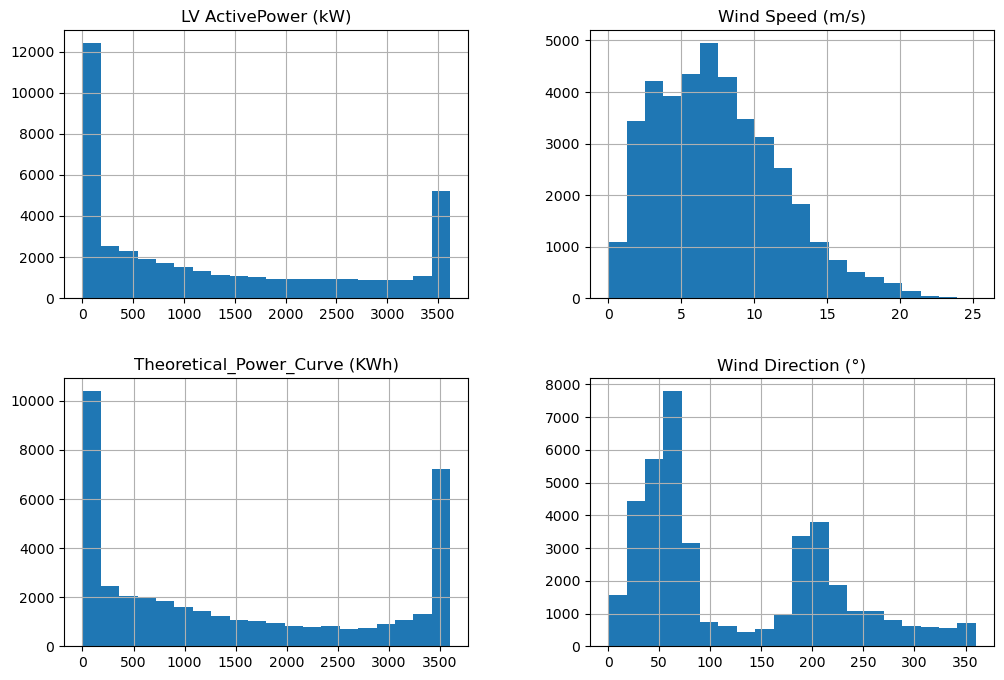

In [23]:
df_train[num_col[:-2]].hist(bins=20,figsize=(12,8));

<a name="3.1"></a>
### 3.1 - Scatter matrix

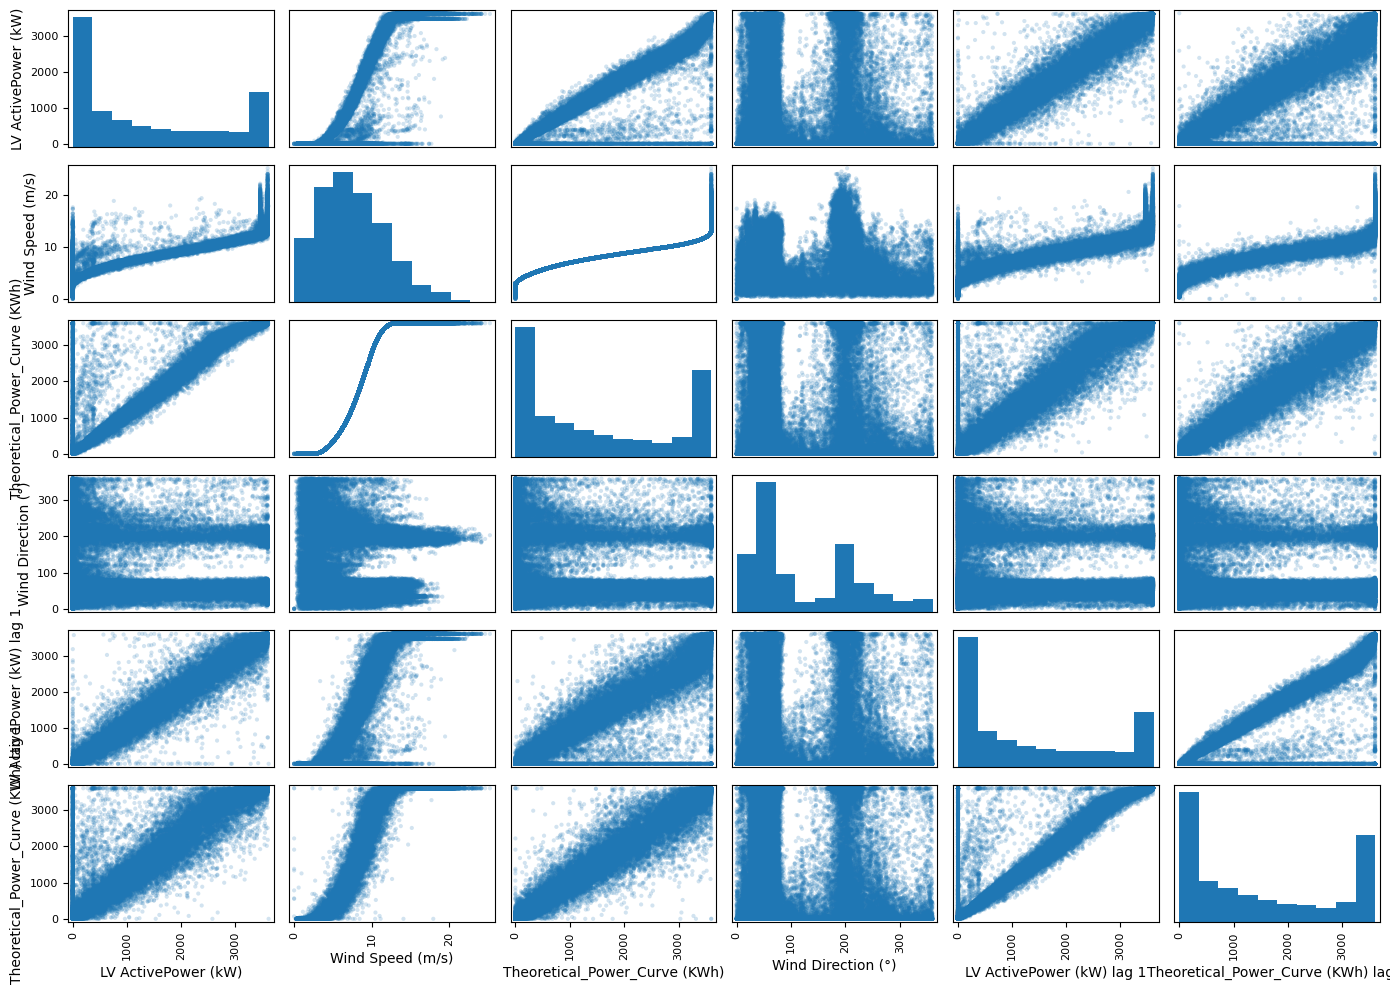

In [24]:
pd.plotting.scatter_matrix(df[num_col], alpha=0.2, figsize=(14, 10))
plt.tight_layout()
plt.show()

- **Comments:**
    - from the scatter plot between `wind speed` and `Theoritical Power Curve`, we see that Wind Turbines Systems can't generate any power if the wind speed is less than 4 m/s
    - when the wind speed is larger than 4 m/s to 11 m/s, the relation between them are linear meaning that increasing the wind speed, allows turbines to generate more power
    - after the wind speed passes 11 m/s, the power generated is saturated on 3600 KWh
    - the autocorrelation in power is really high, suggesting that the best predictor of future power is historical power

<a name="3.2"></a>
### 3.2 - Univariate Analysis

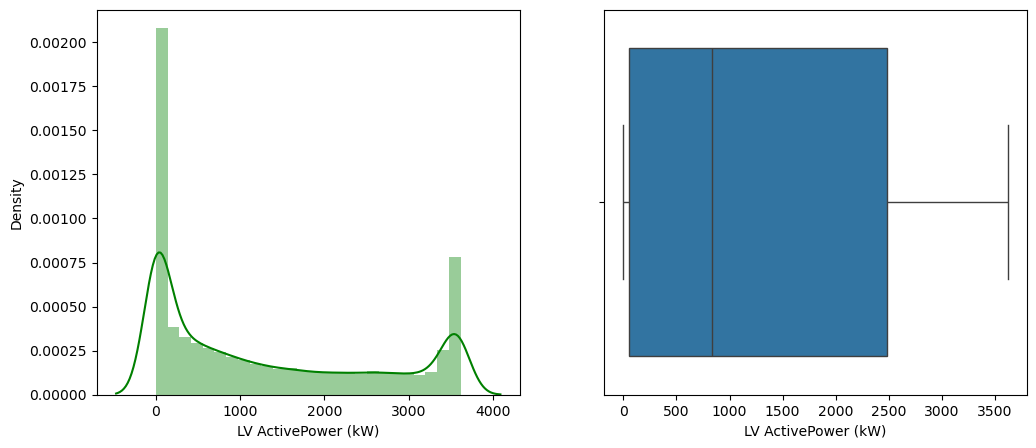

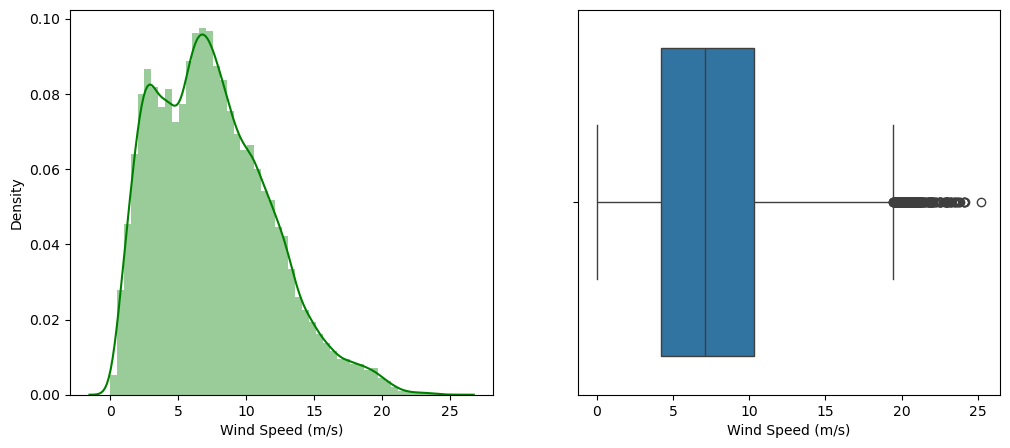

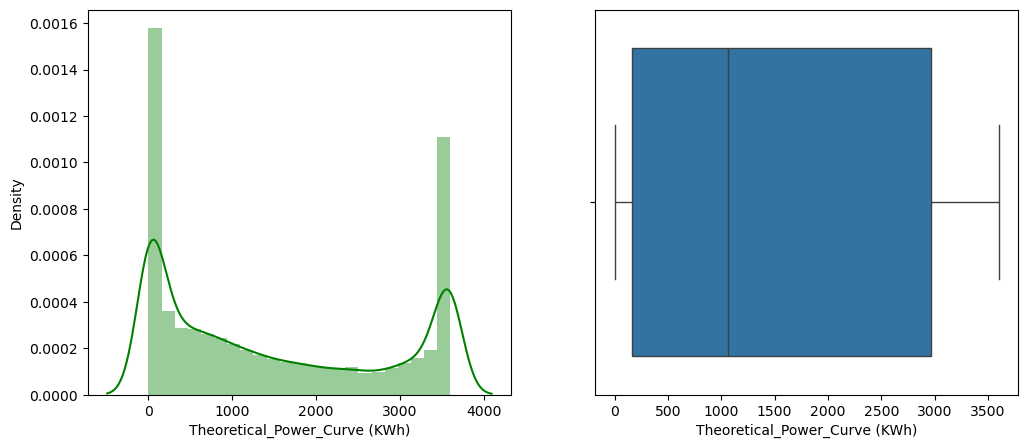

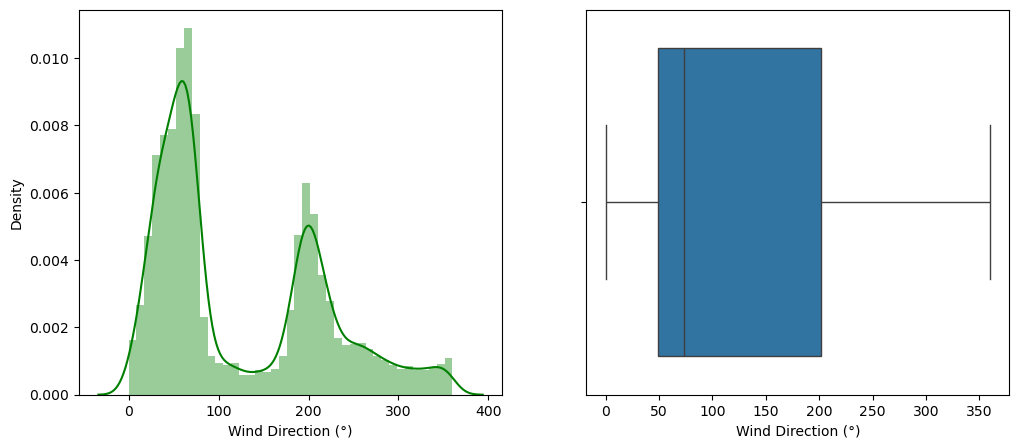

In [25]:
for col in num_col[:-2]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(df_train[col], ax=ax[0] ,color='green')  
    sns.boxplot(x=df_train[col], ax=ax[1])
    plt.show()

- **Comments:**
    - clearly visible is that the wind turbine in the majority of the time is either not orperating or orperating at full capacity.
    - we see that `wind speed` has a lot of outliers, which we are going to cut off, because as noted above the power supply saturates at 3600 kWh

<a name="3.3"></a>
### 3.3 - Plotting Colinearity

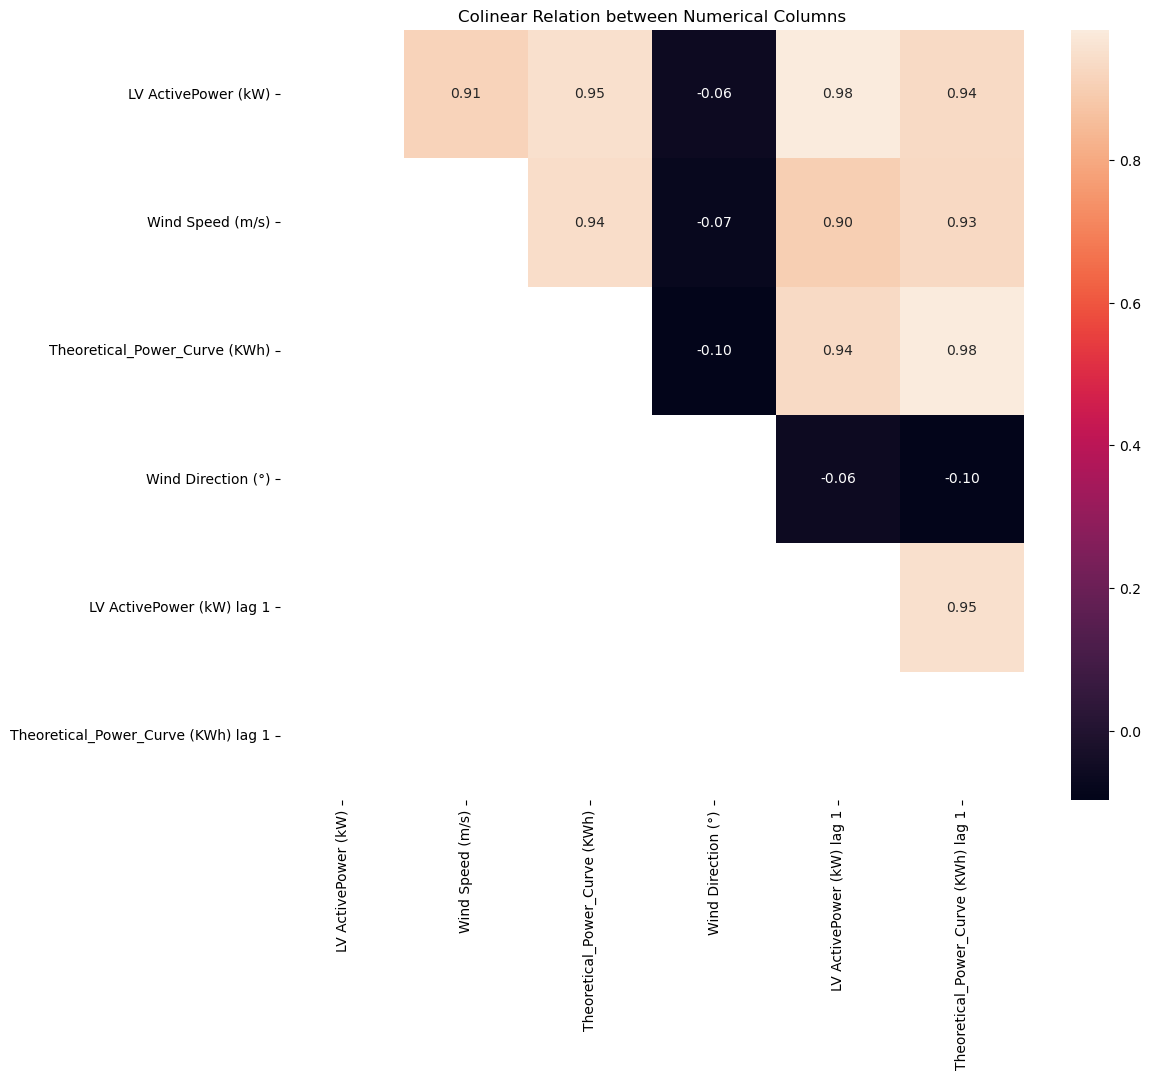

In [26]:
corr = df_train[num_col].corr(numeric_only=True)
mask = np.tril(corr)
mask=mask
plt.figure(figsize=(12, 10))
plt.title('Colinear Relation between Numerical Columns')
sns.heatmap(corr, annot=True,mask=mask, fmt='.2f')
sns.color_palette("magma", as_cmap=True)
plt.show()

<a name="3.4"></a>
## 3.4 - Numerical Columns over the date columns

<h3>Numerical Columns over the Weeks<h3>

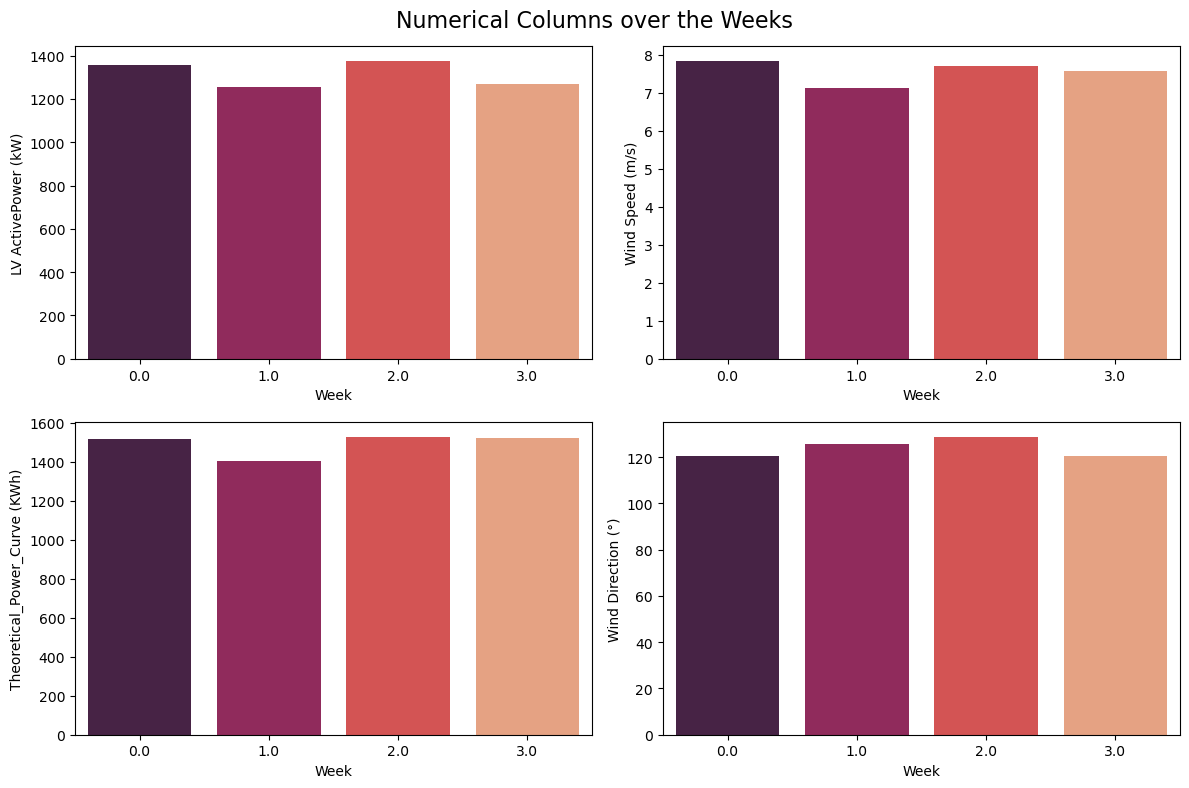

In [27]:
fig,axes=plt.subplots(nrows=len(num_col[:-2])//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col[:-2]]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Week'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Weeks', fontsize=16)
plt.tight_layout()
plt.show()

<h3>Numerical Columns for each Month<h3>

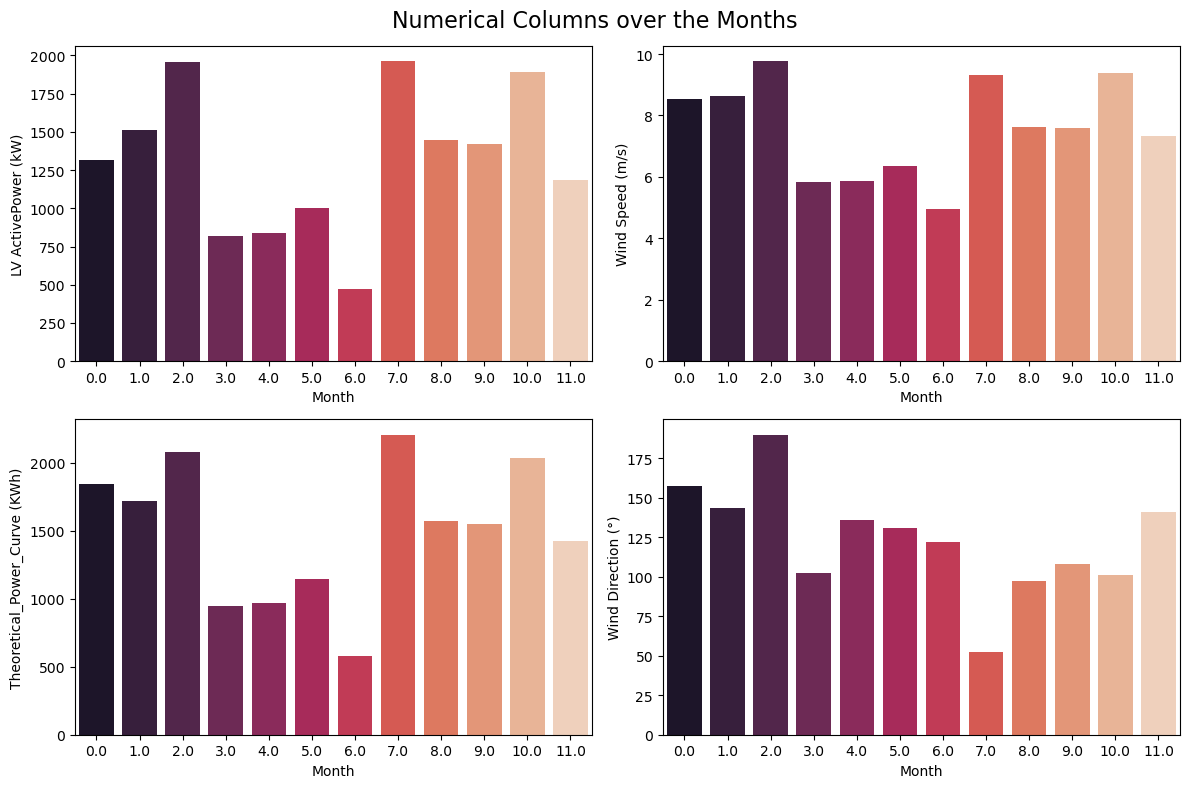

In [28]:
fig,axes=plt.subplots(nrows=len(num_col[:-2])//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col[:-2]]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Month'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Months', fontsize=16)
plt.tight_layout()
plt.show() 

<a name="4"></a>
# 4 - Preprocessing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestRegressor

In [8]:
df = pd.read_csv('data/data_processed.csv')
date_col = ['Week','Month','Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Hour','Day']
num_col= ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'LV ActivePower (kW) lag 1', 'Theoretical_Power_Curve (KWh) lag 1']

In [9]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=42)

In [10]:
#Outlier Equation
def outlier_threshhold(dataframe,column,q1=0.25,q3=0.75):
    Q1=dataframe[column].quantile(q1)
    Q3=dataframe[column].quantile(q3)
    iqr=Q3-Q1
    up_limit=Q3+1.5*iqr
    low_limit=Q1-1.5*iqr
    return low_limit,up_limit


#Outlier Count    
def outlier_percentage(dataframe,column):
    low_limit,up_limit=outlier_threshhold(dataframe,column)
    outliers= [x for x in dataframe[col] if (x>up_limit) | (x<low_limit)]
    print(col)
    # print("Outliers percentage:", len(outliers)#/(dataframe[column].shape[0])*100,"%")
    print("Outliers Count :", len(outliers))
    print("-------------------------")   


#Checking Outliers 
def check_outliers(dataframe,column):
    low_limit,up_limit=outlier_threshhold(dataframe,column)
    outliers=(dataframe[column]>up_limit) | (dataframe[column]<low_limit)
    if outliers.any():
        return True
    else:
        return False


#Replace with IQR     
def replace_with_threshholds(dataframe,dataframe2,column):
    low_limit,up_limit=outlier_threshhold(dataframe,column)
    dataframe.loc[(dataframe[column]<low_limit),column]=low_limit
    dataframe.loc[(dataframe[column]>up_limit),column]=up_limit
    dataframe2.loc[(dataframe2[column]<low_limit),column]=low_limit
    dataframe2.loc[(dataframe2[column]>up_limit),column]=up_limit  


for col in (num_col):
    outlier_percentage(df_train,col)

LV ActivePower (kW)
Outliers Count : 0
-------------------------
Wind Speed (m/s)
Outliers Count : 344
-------------------------
Theoretical_Power_Curve (KWh)
Outliers Count : 0
-------------------------
Wind Direction (°)
Outliers Count : 0
-------------------------
LV ActivePower (kW) lag 1
Outliers Count : 0
-------------------------
Theoretical_Power_Curve (KWh) lag 1
Outliers Count : 0
-------------------------


In [11]:
for column in num_col:
    replace_with_threshholds(df_train,df_test,column)
    print(column,check_outliers(df_train,column))

LV ActivePower (kW) False
Wind Speed (m/s) False
Theoretical_Power_Curve (KWh) False
Wind Direction (°) False
LV ActivePower (kW) lag 1 False
Theoretical_Power_Curve (KWh) lag 1 False


<h3>Split the Target and Label Columns<h3>

In [12]:
# target = 'LV ActivePower (kW) lag 1'
# leave_out_target = 'Theoretical_Power_Curve (KWh) lag 1'

leave_out_target = 'LV ActivePower (kW) lag 1'
target = 'Theoretical_Power_Curve (KWh) lag 1'

X_train, y_train, X_test, y_test = df_train.drop(columns=[target, leave_out_target]), df_train[target], df_test.drop(columns=[target, leave_out_target]), df_test[target]

In [13]:
print("The Shape of X_train is :", X_train.shape)
print("The Shape of y_train is :", y_train.shape)
print("The Shape of X_test is :", X_test.shape)
print("The Shape of y_test is :", y_test.shape)

The Shape of X_train is : (40423, 11)
The Shape of y_train is : (40423,)
The Shape of X_test is : (10106, 11)
The Shape of y_test is : (10106,)


<a name="4.1"></a>
## 4.1 - Scaling

In [14]:
num_col = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
scaler = StandardScaler()

X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [15]:
X_train[num_col].describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,4.042300e+04,4.042300e+04,4.042300e+04,4.042300e+04
mean,-7.945113e-17,2.812430e-18,-8.366978e-17,-1.114425e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-9.991187e-01,-1.800386e+00,-1.092657e+00,-1.325550e+00
25%,-9.578327e-01,-7.976651e-01,-9.736661e-01,-7.968450e-01
50%,-3.649332e-01,-1.061069e-01,-3.126990e-01,-5.347098e-01
75%,8.959375e-01,6.551921e-01,1.077337e+00,8.353190e-01
max,1.758321e+00,2.834478e+00,1.538703e+00,2.532074e+00


<a name="5"></a>
# 5 - Modeling

In [16]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV

In [149]:
model_name = []
r2score = []
rmse = []
models = [
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42)
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name.append(model.__class__.__name__)
    r2score.append(str(r2_score(y_test, y_pred)))
    rmse.append(str(mean_squared_error(y_test, y_pred, squared=False)))

In [150]:
models_df = pd.DataFrame({"Model-Name": model_name, "R2_score": r2score ,'RMSE': rmse})
models_df = models_df.astype({"R2_score": float, "RMSE": float})
models_df = models_df.sort_values("R2_score", ascending = False)

In [151]:
models_df

,Model-Name,R2_score,RMSE
0,GradientBoostingRegressor,0.962934,263.383678
8,XGBRFRegressor,0.962879,263.580691
3,LinearRegression,0.962595,264.585140
7,XGBRegressor,0.961768,267.496605
2,RandomForestRegressor,0.960792,270.887671
4,ExtraTreesRegressor,0.958657,278.166109
6,DecisionTreeRegressor,0.919108,389.094217
5,AdaBoostRegressor,0.916316,395.752480
1,SVR,0.266730,1171.477845


<a name="5.1"></a>
## 5.1 - Plot Model Scores

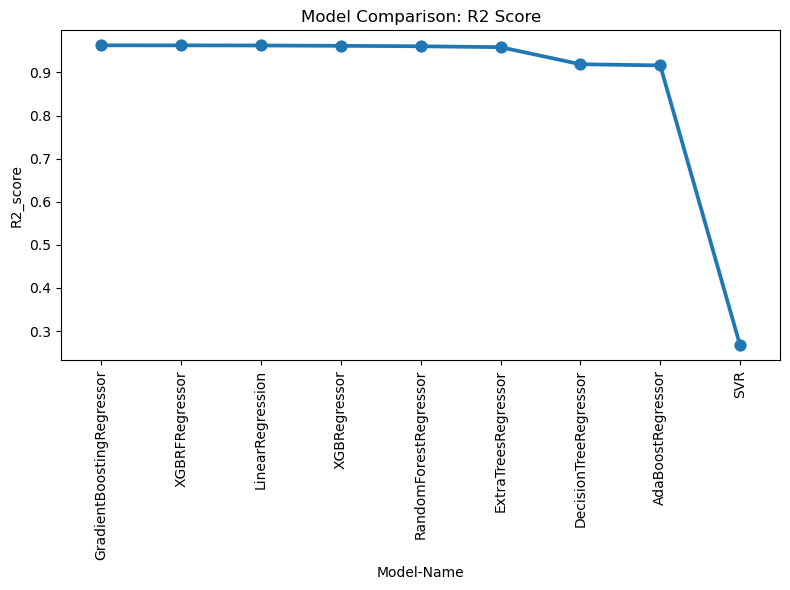

In [152]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='Model-Name', y='R2_score', data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: R2 Score')
plt.tight_layout()
plt.show()

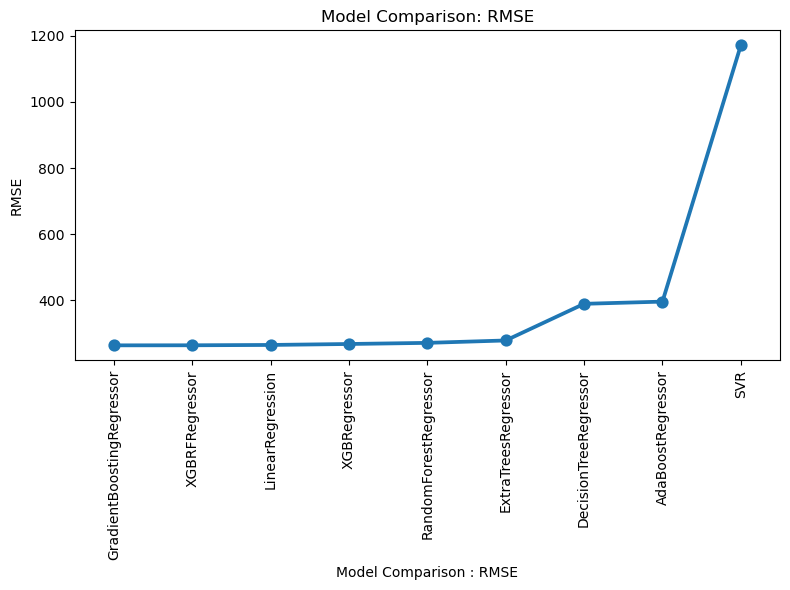

In [153]:
plt.figure(figsize=(8,6))
plt.xlabel('Model Comparison : RMSE')
sns.pointplot(x='Model-Name',y='RMSE',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: RMSE')
plt.tight_layout()
plt.show()

<a name="5.2"></a>
## 5.2 - Final Model

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Fine Tune your model

In [105]:
fm = XGBRegressor(random_state=42)
#Prepare a set of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4],
    #'booster': ['gbtree', 'gblinear'],
    'base_score': [0.25, 0.5, 0.75, 1]
}

In [181]:
#Create the RandomizedSearch object and specify the number of folds for cross-validation
random_search = RandomizedSearchCV(estimator=fm, param_distributions=param_grid, n_iter=50, scoring='r2', n_jobs=-1)

In [182]:
#Fit the RandmoizedSearch object to your training data:
random_search.fit(X_1, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   scoring='r2')

In [183]:
#Inspect the best parameters and score:
best_params = random_search.best_params_
best_score = random_search.best_score_
print('Best Parameters: ', best_params)
print('Best R2: ', best_score)

Best Parameters:  {'n_estimators': 1500, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.15, 'base_score': 0.25}
Best R2:  0.9835904251623475


In [184]:
#Use the best parameters to re-train your model and make predictions on the test data:
best_model = XGBRegressor(**best_params)
best_model.fit(X_1, y_train)
y_pred = best_model.predict(X_1_test)
y_test1=y_test.to_numpy()

In [190]:
#Evaluate the performance of the best model using your preferred metric
r2 = r2_score(y_test1, y_pred )
print('R2 Score: ', r2)

R2 Score:  0.983697134619831


<a name="5.3"></a>
## 5.3 - Cross-Validation Scores

In [18]:
cross_val = cross_val_score(model, X_test, y_test, scoring='r2', cv=20)
print(cross_val)

[0.96762048 0.96792679 0.96834102 0.96703274 0.9622442  0.96662635
 0.95947418 0.95722971 0.95714447 0.9596173  0.95900952 0.96267759
 0.94893346 0.96418165 0.96741381 0.97075632 0.96029894 0.96115142
 0.95417661 0.9661778 ]


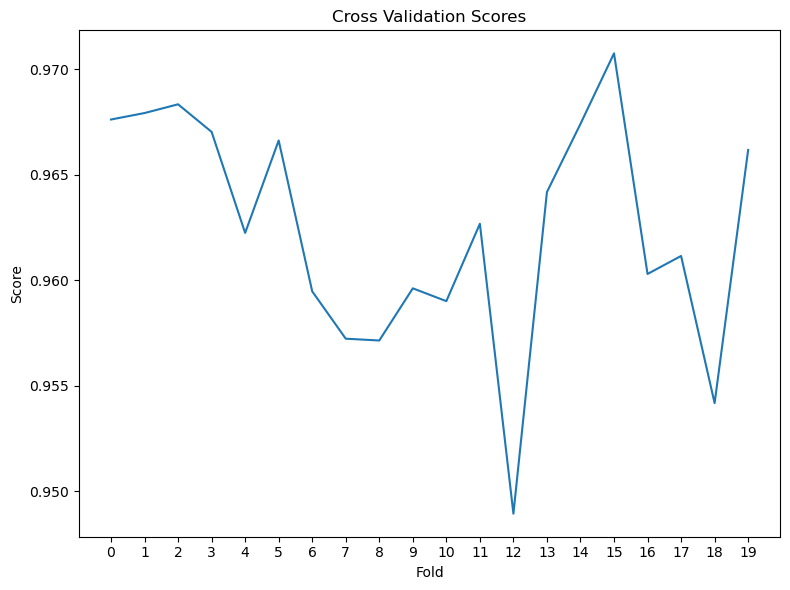

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(cross_val)
plt.title("Cross Validation Scores")
plt.ylabel("Score")
plt.xlabel("Fold")
plt.xticks(np.arange(0,20))
plt.tight_layout()
plt.show()

In [20]:
print(cross_val.mean())

0.9624017181294734


In [21]:
y_test

8057     2005.288074
8059     3404.201404
50249     779.117347
14774    1645.530614
49373     593.890170
            ...     
20904    1390.284957
17208      37.707783
34567    1356.473513
33265     474.729727
35032       0.000000
Name: Theoretical_Power_Curve (KWh) lag 1, Length: 10106, dtype: float64

In [55]:
data_new = pd.DataFrame({'Theoretical_Power_Curve (KWh) lag 1': y_test})
data_new['Predictions'] = y_pred
data_new["LV ActivePower (kW) lag 1"] = df["LV ActivePower (kW) lag 1"]

data_new.head()

,Theoretical_Power_Curve (KWh) lag 1,Predictions,LV ActivePower (kW) lag 1
8057,2005.288074,3400.091040,2042.970947
8059,3404.201404,2937.440529,3197.572998
50249,779.117347,865.745387,0.000000
14774,1645.530614,1501.084772,1297.586060
49373,593.890170,607.934014,533.002808


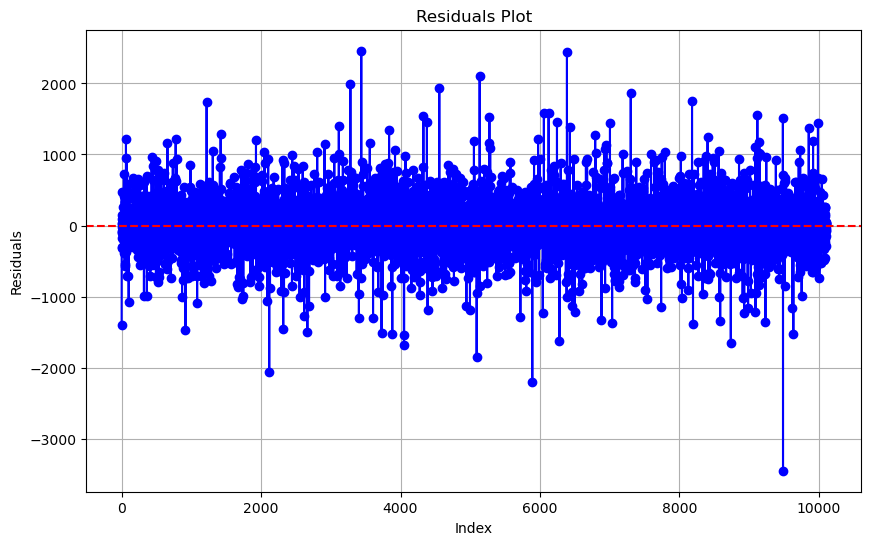

In [53]:
residuals = data_new['Theoretical_Power_Curve (KWh) lag 1'] - data_new['Predictions']
residuals.reset_index(inplace=True, drop=True)
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, marker='o', linestyle='-', color='blue')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Adds a reference line at 0
plt.grid(True)
plt.show()

<a name="6"></a>
# 6 - Plot Predicted vs Real vs Theoretical Power

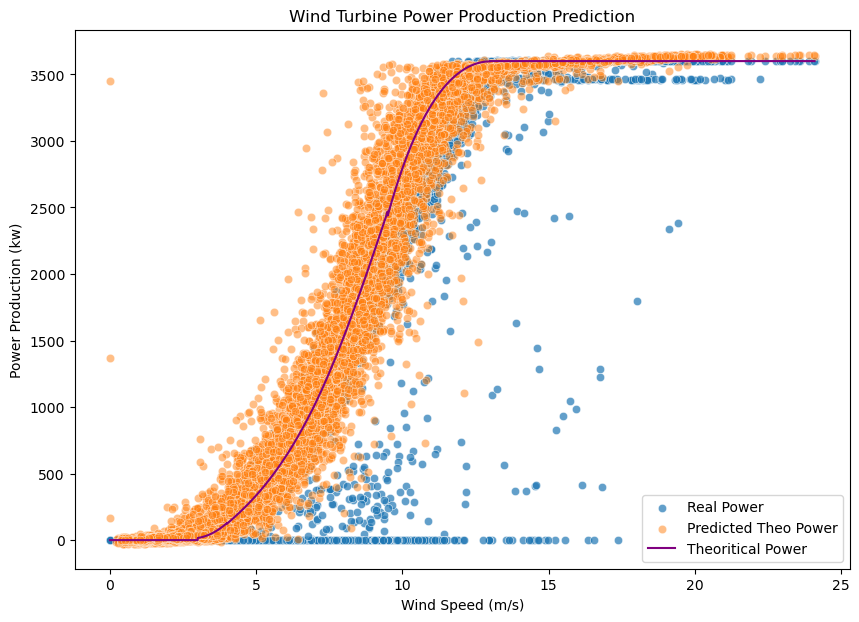

In [57]:
plt.figure(figsize=(10,7))
x = df['Wind Speed (m/s)'].shift(-1)
sns.scatterplot(x=x, y=data_new['LV ActivePower (kW) lag 1'],alpha=0.7, label= 'Real Power')
sns.scatterplot(x=x, y=data_new['Predictions'], alpha=0.5, label='Predicted Theo Power', marker='o')
sns.lineplot(x=x, y=data_new["Theoretical_Power_Curve (KWh) lag 1"], label='Theoritical Power',color='purple')
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend()
plt.show()

<a name="7"></a>
# 7 - Performance Improvement

In [59]:
data_new['Power Difference'] = data_new['Predictions'] - data_new['LV ActivePower (kW) lag 1']
data_new['Moving Average'] = data_new['Power Difference'].rolling(100).mean()
data_new.reset_index(inplace=True, drop=True)
data_new.head()

,Theoretical_Power_Curve (KWh) lag 1,Predictions,LV ActivePower (kW) lag 1,Power Difference,Moving Average
0,2005.288074,3400.091040,2042.970947,1357.120093,NaN
1,3404.201404,2937.440529,3197.572998,-260.132469,NaN
2,779.117347,865.745387,0.000000,865.745387,NaN
3,1645.530614,1501.084772,1297.586060,203.498713,NaN
4,593.890170,607.934014,533.002808,74.931206,NaN


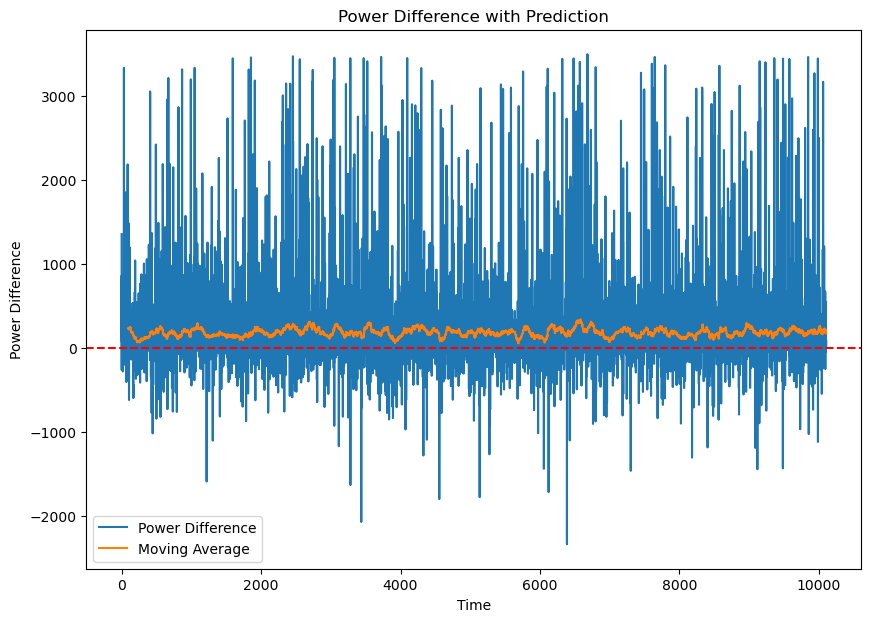

In [62]:
data_new[['Power Difference', 'Moving Average']].plot(figsize=(10, 7))
plt.title('Power Difference with Prediction')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Difference')
plt.show()

In [44]:
total_bonus_kwh = (data_new['Power Difference'] / 6).sum()
print(total_bonus_kwh)

312477.94030893873


In [45]:
num_of_houses = total_bonus_kwh / 4000
print(num_of_houses)

78.11948507723469


In [66]:
num_wind_turbines = 30243
houses_total = num_wind_turbines * num_of_houses

muc_houses = 834542
print('Houses total: ' + str(houses_total))
print('Times MUC: ' + str(houses_total / muc_houses))

Houses total: 2362567.5871908087
Times MUC: 2.830975058404261
